In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sympy as sp
import numpy as np
from sympy import symbols
from sympy.physics.mechanics import *
mechanics_printing()

S = symbols
DS = dynamicsymbols

#suppress warnings
import warnings
from matplotlib import MatplotlibDeprecationWarning
warnings.filterwarnings("ignore", category=MatplotlibDeprecationWarning)

# Generalized Coordinates
6 independent degrees of freedom:
* 3 for orientation (+1 dep due to quaternion representation)
* 3 for position

In [3]:
#inertial frame
NED = ReferenceFrame('NED')
NED_o = Point('NED_o')
NED_o.set_vel(NED, 0)

#body frame
q_att = DS('λ_0:4', real=True)
B = NED.orientnew('B', 'Quaternion', q_att)

q_pos = DS('B_x:z')
B_cm = NED_o.locatenew('B_cm', q_pos[0]*B.x + q_pos[1]*B.y + q_pos[2]*B.z)

q_ind = q_att[1:] + q_pos
q_dep = [q_att[0]]
q_ind, q_dep

# Generalized Speeds and kinematic equations
6 as well, 3 linear and 3 angular

In [4]:
kinematic_eqs = []
speed_cons = []  

B_ang_vel = B.ang_vel_in(NED)
P, Q, R = DS('P Q R')
B.set_ang_vel(NED, P*B.x + Q*B.y + R*B.z)

B_ang_vel_kd = (B.ang_vel_in(NED) - B_ang_vel).simplify()

#Equating the two gives us the kinematic equation
kinematic_eqs += [
    B_ang_vel_kd & B.x,
    B_ang_vel_kd & B.y,
    B_ang_vel_kd & B.z
]

The order of whether we express B in PQR first or not before 
computing B_cm_vel makes a HUUUGE difference for the explicit form. Indeed, if B_cm is a function of $\dot{\lambda}$, sympy is unable to solve the kinematics explicitly (while implicit treatment is fine)

In [5]:
B_cm_vel = B_cm.vel(NED)
U, V, W = DS('U V W')
B_cm.set_vel(NED, U*B.x + V*B.y + W*B.z)

# Compute the velocity of the point using the two methods
B_ref_vel_kd = (B_cm.vel(NED) - B_cm_vel)

#taking dot product with unit vectors to get kinematic equations
#relating body coordinates and velocities

#Note, there is a choice to dot with NED.xyz here. That makes
#the implicit form have some bigger terms but is still fine, the
#explicit form still struggles though
kinematic_eqs += [ 
                  B_ref_vel_kd & B.x, 
                  B_ref_vel_kd & B.y, 
                  B_ref_vel_kd & B.z,
                 ]

u_ind = [U, V, W, P, Q, R]

## Dependent coordinate equations
We need one additional kinematic equation, and a constraint:

* the addition kinematic equation comes from the q.T * dq/dt = 0 property
* the constraint comes from the quaternion needing to be unit norm

Note that we could have written the kinematic equations for the quaternion
directly from dq/dt = Ω * q / 2 property, but that's basically an explicit 
solution to the kinematics. Because we want to illustrate the issue when equations are
explicit, we won't use that shortcut

In [6]:
q_att_vec = sp.Matrix(q_att)
config_cons = [q_att_vec.norm()**2 - 1] #unit norm
kinematic_eqs = kinematic_eqs + [(q_att_vec.T * q_att_vec.diff())[0]]

In [7]:
sp.Matrix(kinematic_eqs), config_cons

⎛⎡P - 2⋅λ₀⋅λ₁̇ + 2⋅λ₁⋅λ₀̇ + 2⋅λ₂⋅λ₃̇ - 2⋅λ₃⋅λ₂̇⎤                             ⎞
⎜⎢                                         ⎥                             ⎟
⎜⎢Q - 2⋅λ₀⋅λ₂̇ - 2⋅λ₁⋅λ₃̇ + 2⋅λ₂⋅λ₀̇ + 2⋅λ₃⋅λ₁̇⎥                             ⎟
⎜⎢                                         ⎥                             ⎟
⎜⎢R - 2⋅λ₀⋅λ₃̇ + 2⋅λ₁⋅λ₂̇ - 2⋅λ₂⋅λ₁̇ + 2⋅λ₃⋅λ₀̇⎥                             ⎟
⎜⎢                                         ⎥  ⎡  2     2     2     2    ⎤⎟
⎜⎢         B_y⋅R - B_z⋅Q + U - Bₓ̇          ⎥, ⎣λ₀  + λ₁  + λ₂  + λ₃  - 1⎦⎟
⎜⎢                                         ⎥                             ⎟
⎜⎢         -Bₓ⋅R + B_z⋅P + V - B_̇y         ⎥                             ⎟
⎜⎢                                         ⎥                             ⎟
⎜⎢         Bₓ⋅Q - B_y⋅P + W - B_̇z          ⎥                             ⎟
⎜⎢                                         ⎥                             ⎟
⎝⎣      λ₀⋅λ₀̇ + λ₁⋅λ₁̇ + λ₂⋅λ₂̇ + λ₃⋅λ₃̇      ⎦                             ⎠

# Rigid body and forces

In [8]:
#mass
M_B = S('M_B')

#inertia dyadic relative to CM
J_B = inertia(B, *[S(f'J_B_{ax}')*(1 if ax[0] == ax[1] else -1)
        for ax in ['xx', 'yy', 'zz', 'xy', 'yz', 'xz']])
#Assume symmetry around xz for this body
J_B = msubs(J_B, {S('J_B_xy'): 0, S('J_B_yz'): 0})

RB = RigidBody('RB', B_cm, B, M_B, (J_B, B_cm))

rigid_bodies = [RB]

In [9]:
# Forces
ForceList = [
    #gravity pointing down
    (RB.masscenter, RB.mass*S('g')*NED.z),
    #generic forces and torques in body frame(inputs)
    (RB.frame, DS('T_x')*B.x + DS('T_y')*B.y + DS('T_z')*B.z),
    (RB.masscenter, DS('F_x')*B.x + DS('F_y')*B.y + DS('F_z')*B.z) 
]

# Comparing explicit vs implicit method

In [10]:
KM_dict = {}
def getKane(explicit_kinematics = False, build_M_and_f = False, kd_eqs = kinematic_eqs):
    '''
    get a KanesMethod object with or without explicit kinematics 
    '''
    KM = KanesMethod(NED, q_ind, u_ind, 
          q_dependent= q_dep,
          kd_eqs = kinematic_eqs, explicit_kinematics=explicit_kinematics,
          configuration_constraints = config_cons,
          velocity_constraints= [],
          u_dependent= [], #no dependent speeds          
          u_auxiliary = [] # No auxiliary speeds
        )
    
    if build_M_and_f:
        KM.kanes_equations(rigid_bodies, ForceList)
    
    KM_dict['explicit' if explicit_kinematics else 'implicit'] = KM

Time method using old behavior (explicit_kinematics=True)
vs. new behavior (explicit_kinematics=False)

In [11]:
%timeit -n1 -r1 getKane(explicit_kinematics = False)
%timeit -n1 -r1 getKane(explicit_kinematics = True)

77.5 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
134 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


Doesn't look so bad just creating the object, but let's now run the equations to build M and f

In [12]:
%timeit -n1  getKane(explicit_kinematics = False, build_M_and_f = True)

140 ms ± 11.8 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [13]:
KM_dict['implicit'].mass_matrix_full, KM_dict['implicit'].forcing_full

⎛                                                                                  ⎡                
⎜⎡-2⋅λ₀  -2⋅λ₃  2⋅λ₂   0   0   0   2⋅λ₁   0    0    0      0       0        0   ⎤  ⎢                
⎜⎢                                                                              ⎥  ⎢                
⎜⎢2⋅λ₃   -2⋅λ₀  -2⋅λ₁  0   0   0   2⋅λ₂   0    0    0      0       0        0   ⎥  ⎢                
⎜⎢                                                                              ⎥  ⎢                
⎜⎢-2⋅λ₂  2⋅λ₁   -2⋅λ₀  0   0   0   2⋅λ₃   0    0    0      0       0        0   ⎥  ⎢                
⎜⎢                                                                              ⎥  ⎢                
⎜⎢  0      0      0    -1  0   0    0     0    0    0      0       0        0   ⎥  ⎢                
⎜⎢                                                                              ⎥  ⎢                
⎜⎢  0      0      0    0   -1  0    0     0    0    0      0       0        0   ⎥  ⎢       

The explicit kinematics approach takes about 3 times longer:

In [14]:
%timeit -n1  getKane(explicit_kinematics = True , build_M_and_f = True)

The slowest run took 4.81 times longer than the fastest. This could mean that an intermediate result is being cached.
511 ms ± 422 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


We can see that part of the issue is that the explicit kinematic expression, although computed quickly, is big ...

In [15]:
print(KM_dict['explicit'].forcing_kin[0])

(-2*(1 + (λ_3(t) + λ_1(t)*λ_2(t)/λ_0(t) - (-2*λ_1(t) + 2*λ_2(t)*λ_3(t)/λ_0(t))*(λ_2(t) - λ_1(t)*λ_3(t)/λ_0(t))/(-2*λ_0(t) - 2*λ_3(t)**2/λ_0(t)))*(2*λ_3(t) - 2*λ_1(t)*λ_2(t)/λ_0(t) - (2*λ_1(t) + 2*λ_2(t)*λ_3(t)/λ_0(t))*(2*λ_2(t) + 2*λ_1(t)*λ_3(t)/λ_0(t))/(-2*λ_0(t) - 2*λ_3(t)**2/λ_0(t)))/((-2*λ_0(t) - 2*λ_2(t)**2/λ_0(t) - (-2*λ_1(t) + 2*λ_2(t)*λ_3(t)/λ_0(t))*(2*λ_1(t) + 2*λ_2(t)*λ_3(t)/λ_0(t))/(-2*λ_0(t) - 2*λ_3(t)**2/λ_0(t)))*(λ_0(t) + λ_1(t)**2/λ_0(t) - (λ_3(t) + λ_1(t)*λ_2(t)/λ_0(t) - (-2*λ_1(t) + 2*λ_2(t)*λ_3(t)/λ_0(t))*(λ_2(t) - λ_1(t)*λ_3(t)/λ_0(t))/(-2*λ_0(t) - 2*λ_3(t)**2/λ_0(t)))*(2*λ_3(t) - 2*λ_1(t)*λ_2(t)/λ_0(t) - (2*λ_1(t) + 2*λ_2(t)*λ_3(t)/λ_0(t))*(2*λ_2(t) + 2*λ_1(t)*λ_3(t)/λ_0(t))/(-2*λ_0(t) - 2*λ_3(t)**2/λ_0(t)))/(-2*λ_0(t) - 2*λ_2(t)**2/λ_0(t) - (-2*λ_1(t) + 2*λ_2(t)*λ_3(t)/λ_0(t))*(2*λ_1(t) + 2*λ_2(t)*λ_3(t)/λ_0(t))/(-2*λ_0(t) - 2*λ_3(t)**2/λ_0(t))) - (λ_2(t) - λ_1(t)*λ_3(t)/λ_0(t))*(2*λ_2(t) + 2*λ_1(t)*λ_3(t)/λ_0(t))/(-2*λ_0(t) - 2*λ_3(t)**2/λ_0(t)))))*λ_2(t)/(-2*λ_0(

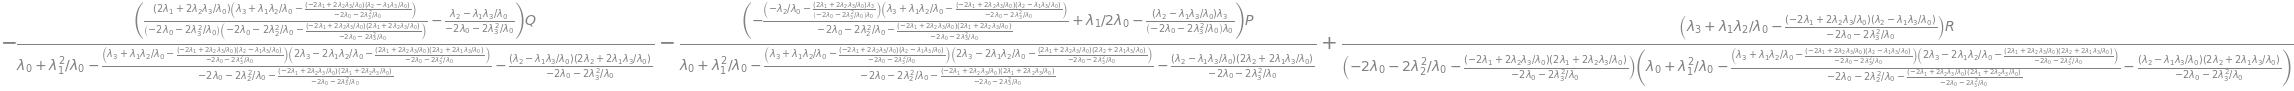

In [16]:
KM_dict['explicit'].forcing_kin[-1]

Of course in this example the dynamics are ok because no q_dot terms showed up in the forcing function, had they showed up, then the big expressions from explicit symbolic solve of kinematics end up in the dynamic equations as well

Note that one option, which works in some cases, is to simplify the expressions, but this can slow down things a lot if the expression is too big.

Also note that 

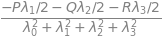

In [17]:
sp.simplify(KM_dict['explicit'].forcing_kin[-1])

In [18]:
# Simplifying all of the equations doesn't finish within reasonable time
## sp.simplify(KM_dict['explicit'].forcing_kin)

### Verifying the implicit form

Of course, if we could simplify that expression, or provide it directly in explicit form,
this wouldn't be an issue. But that's a limitation as it requires manually solving for an implicit form,
which defeats the purpose of using sympy :p and a simplification of the expressions above are likely to be exteremly slow.

For completeness, we show that the explicit form of the kinematics for the attitude that are derived in textbooks are indeed consistent with the implicit form
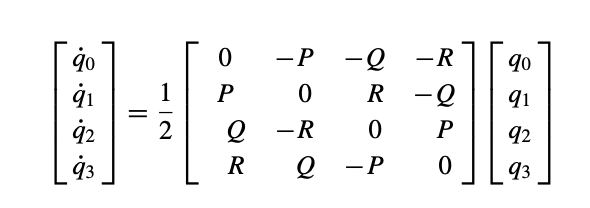

In [19]:
q_dot_textbook = sp.Matrix([
    [0, -P, -Q, -R],
    [P,  0,  R, -Q],
    [Q, -R,  0,  P],
    [R,  Q, -P,  0],
]) * q_att_vec / 2
q_dot_textbook

⎡  P⋅λ₁   Q⋅λ₂   R⋅λ₃⎤
⎢- ──── - ──── - ────⎥
⎢   2      2      2  ⎥
⎢                    ⎥
⎢ P⋅λ₀   Q⋅λ₃   R⋅λ₂ ⎥
⎢ ──── - ──── + ──── ⎥
⎢  2      2      2   ⎥
⎢                    ⎥
⎢ P⋅λ₃   Q⋅λ₀   R⋅λ₁ ⎥
⎢ ──── + ──── - ──── ⎥
⎢  2      2      2   ⎥
⎢                    ⎥
⎢  P⋅λ₂   Q⋅λ₁   R⋅λ₀⎥
⎢- ──── + ──── + ────⎥
⎣   2      2      2  ⎦

In [25]:
KM_dict['implicit'].q.T

[λ₁  λ₂  λ₃  Bₓ  B_y  B_z  λ₀]

In [26]:
#sympy's Kane puts the dependent coordinate last
q_dot_candidate_sol = KM_dict['implicit'].q.diff()

q_dot_candidate_sol[-1] = q_dot_textbook[0]
q_dot_candidate_sol[0]  = q_dot_textbook[1]
q_dot_candidate_sol[1]  = q_dot_textbook[2]
q_dot_candidate_sol[2]  = q_dot_textbook[3]
q_dot_candidate_sol.T

⎡P⋅λ₀   Q⋅λ₃   R⋅λ₂  P⋅λ₃   Q⋅λ₀   R⋅λ₁    P⋅λ₂   Q⋅λ₁   R⋅λ₀                  P⋅λ₁   Q⋅λ₂   R⋅λ₃⎤
⎢──── - ──── + ────  ──── + ──── - ────  - ──── + ──── + ────  Bₓ̇  B_̇y  B_̇z  - ──── - ──── - ────⎥
⎣ 2      2      2     2      2      2       2      2      2                     2      2      2  ⎦

In [27]:
rhs_candidate = sp.simplify(KM_dict['implicit'].mass_matrix_kin * q_dot_candidate_sol)

In [23]:
sp.Eq(rhs_candidate[0:4, 0] , KM_dict['implicit'].forcing_kin[0:4, 0])

⎡⎛    2     2     2     2⎞  ⎤                       
⎢⎝- λ₀  - λ₁  - λ₂  - λ₃ ⎠⋅P⎥                       
⎢                           ⎥   ⎡        -P        ⎤
⎢⎛    2     2     2     2⎞  ⎥   ⎢                  ⎥
⎢⎝- λ₀  - λ₁  - λ₂  - λ₃ ⎠⋅Q⎥   ⎢        -Q        ⎥
⎢                           ⎥ = ⎢                  ⎥
⎢⎛    2     2     2     2⎞  ⎥   ⎢        -R        ⎥
⎢⎝- λ₀  - λ₁  - λ₂  - λ₃ ⎠⋅R⎥   ⎢                  ⎥
⎢                           ⎥   ⎣-B_y⋅R + B_z⋅Q - U⎦
⎣            -Bₓ̇            ⎦                       

Which holds for q_att_vec.norm() == 1